In [50]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import os
import cv2
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
from per_segment_anything import sam_model_registry, SamPredictor

In [51]:
from IPython.display import display, Image

In [52]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [53]:
class Mask_Weights(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(2, 1, requires_grad=True) / 3)

In [54]:
def point_selection(mask_sim, topk=1):
    # Top-1 point selection
    w, h = mask_sim.shape
    topk_xy = mask_sim.flatten(0).topk(topk)[1]
    topk_x = (topk_xy // h).unsqueeze(0)
    topk_y = (topk_xy - topk_x * h)
    topk_xy = torch.cat((topk_y, topk_x), dim=0).permute(1, 0)
    topk_label = np.array([1] * topk)
    topk_xy = topk_xy.cpu().numpy()
    
    return topk_xy, topk_label


def calculate_dice_loss(inputs, targets, num_masks = 1):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    inputs = inputs.flatten(1)
    numerator = 2 * (inputs * targets).sum(-1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.sum() / num_masks


def calculate_sigmoid_focal_loss(inputs, targets, num_masks = 1, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.mean(1).sum() / num_masks

In [55]:
ref_folder_path = "20250310_demo"
images_folder_path = "C:/Users/4039423/Desktop/N.I.P._ver.7.4.0.0/binary/python/CFIL_for_NIP/train_data/20250310_demo/image/"
output_path = 'outputs'
ext = "jpg"

os.makedirs(output_path, exist_ok=True)

In [56]:
lr = 1e-3
train_epoch = 1000
log_epoch = 200
sam_type = "vit_t"

In [57]:
print("\n------------> Segment ")
    
# Path preparation
ref_image_path = os.path.join(ref_folder_path, f'original.{ext}')
ref_mask_path = os.path.join(ref_folder_path, f'mask.{ext}')
test_images_path = images_folder_path

# Load images and masks
ref_image = cv2.imread(ref_image_path)
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
ref_image = cv2.resize(ref_image,None,fx=0.1,fy=0.1)

ref_mask = cv2.imread(ref_mask_path)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
ref_mask = cv2.resize(ref_mask,None,fx=0.1,fy=0.1)

gt_mask = torch.tensor(ref_mask)[:, :, 0] > 0 
gt_mask = gt_mask.float().unsqueeze(0).flatten(1).cuda()


------------> Segment 


In [58]:
print("======> Load SAM" )
if sam_type == 'vit_h':
    sam_type, sam_ckpt = 'vit_h', '../sam/sam_vit_h.pth'
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).cuda()
elif sam_type == 'vit_t':
    sam_type, sam_ckpt = 'vit_t', '../sam/mobile_sam.pt'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).to(device=device)
    sam.eval()


for name, param in sam.named_parameters():
    param.requires_grad = False
predictor = SamPredictor(sam)

======> Load SAM


In [59]:
print("======> Obtain Self Location Prior" )
# Image features encoding
ref_mask = predictor.set_image(ref_image, ref_mask)
ref_feat = predictor.features.squeeze().permute(1, 2, 0)

ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]

# Target feature extraction
target_feat = ref_feat[ref_mask > 0]
target_feat_mean = target_feat.mean(0)
target_feat_max = torch.max(target_feat, dim=0)[0]
target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)

# Cosine similarity
h, w, C = ref_feat.shape
target_feat = target_feat / target_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat / ref_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat.permute(2, 0, 1).reshape(C, h * w)
sim = target_feat @ ref_feat

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = predictor.model.postprocess_masks(
                sim,
                input_size=predictor.input_size,
                original_size=predictor.original_size).squeeze()

# Positive location prior
topk_xy, topk_label = point_selection(sim, topk=1)

======> Obtain Self Location Prior


In [60]:
def sim_to_heatmap(sim):
    if torch.is_tensor(sim):
        x = sim.to("cpu").detach().numpy().copy()
    else:
        x = sim.copy()
    h, w = x.shape
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = (x * 255).reshape(-1)
    cm = plt.get_cmap("jet")
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return (x * 255).astype(np.uint8).reshape(h, w, 3)

# heat_map = sim_to_heatmap(sim)
# plt.figure(figsize=(10,10))
# plt.imshow(heat_map)
# plt.axis('on')
# plt.show()  

In [61]:
print('======> Start Training')
# Learnable mask weights
mask_weights = Mask_Weights().cuda()
mask_weights.train()

optimizer = torch.optim.AdamW(mask_weights.parameters(), lr=lr, eps=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, train_epoch)

for train_idx in range(train_epoch):

    # Run the decoder
    masks, scores, logits, logits_high = predictor.predict(
        point_coords=topk_xy,
        point_labels=topk_label,
        multimask_output=True)
    logits_high = logits_high.flatten(1)

    # Weighted sum three-scale masks
    weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
    logits_high = logits_high * weights
    logits_high = logits_high.sum(0).unsqueeze(0)

    dice_loss = calculate_dice_loss(logits_high, gt_mask)
    focal_loss = calculate_sigmoid_focal_loss(logits_high, gt_mask)
    loss = dice_loss + focal_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if train_idx % log_epoch == 0:
        print('Train Epoch: {:} / {:}'.format(train_idx, train_epoch))
        current_lr = scheduler.get_last_lr()[0]
        print('LR: {:.6f}, Dice_Loss: {:.4f}, Focal_Loss: {:.4f}'.format(current_lr, dice_loss.item(), focal_loss.item()))


mask_weights.eval()
weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
weights_np = weights.detach().cpu().numpy()
print('======> Mask weights:\n', weights_np)

======> Start Training
Train Epoch: 0 / 1000
LR: 0.001000, Dice_Loss: 0.0103, Focal_Loss: 0.0010
Train Epoch: 200 / 1000
LR: 0.000904, Dice_Loss: 0.0086, Focal_Loss: 0.0012
Train Epoch: 400 / 1000
LR: 0.000653, Dice_Loss: 0.0081, Focal_Loss: 0.0012
Train Epoch: 600 / 1000
LR: 0.000344, Dice_Loss: 0.0078, Focal_Loss: 0.0012
Train Epoch: 800 / 1000
LR: 0.000095, Dice_Loss: 0.0077, Focal_Loss: 0.0012
======> Mask weights:
 [[-0.02502906]
 [ 0.6920795 ]
 [ 0.33294958]]


In [ ]:
print('======> Start Testing')

# Load test image
# file_name = 'image_almi'
file_name = 'image_0028'
test_image_path = os.path.join(test_images_path, f"{file_name}.{ext}" )
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
# test_image = cv2.resize(test_image,None,fx=0.1,fy=0.1)

# Image feature encoding
predictor.set_image(test_image)
test_feat = predictor.features.squeeze()

# Cosine similarity
C, h, w = test_feat.shape
test_feat = test_feat / test_feat.norm(dim=0, keepdim=True)
test_feat = test_feat.reshape(C, h * w)
sim = target_feat @ test_feat

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = predictor.model.postprocess_masks(
                sim,
                input_size=predictor.input_size,
                original_size=predictor.original_size).squeeze()

# Positive location prior
topk_xy, topk_label = point_selection(sim, topk=1)
print(topk_xy, topk_label)

# First-step prediction
masks, scores, logits, logits_high = predictor.predict(
            point_coords=topk_xy,
            point_labels=topk_label,
            multimask_output=True)

# Weighted sum three-scale masks
logits_high = logits_high * weights.unsqueeze(-1)
logit_high = logits_high.sum(0)
mask = (logit_high > 0).detach().cpu().numpy()

logits = logits * weights_np[..., None]
logit = logits.sum(0)

# Cascaded Post-refinement-1
y, x = np.nonzero(mask)
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
input_box = np.array([x_min, y_min, x_max, y_max])
masks, scores, logits, _ = predictor.predict(
    point_coords=topk_xy,
    point_labels=topk_label,
    box=input_box[None, :],
    mask_input=logit[None, :, :],
    multimask_output=True)
best_idx = np.argmax(scores)

# Cascaded Post-refinement-2
y, x = np.nonzero(masks[best_idx])
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
input_box = np.array([x_min, y_min, x_max, y_max])
masks, scores, logits, _ = predictor.predict(
    point_coords=topk_xy,
    point_labels=topk_label,
    box=input_box[None, :],
    mask_input=logits[best_idx: best_idx + 1, :, :],
    multimask_output=True)
best_idx = np.argmax(scores)

======> Start Testing
[[218  79]] [1]


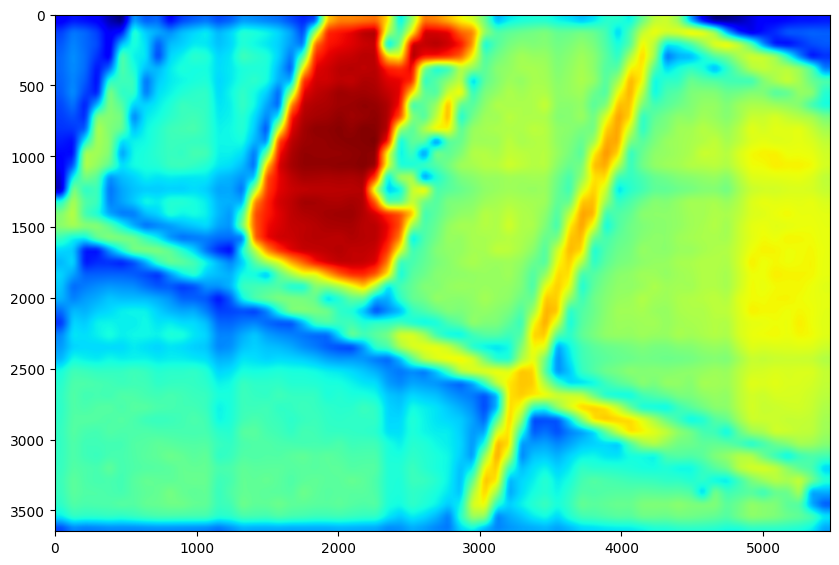

In [48]:
heat_map = sim_to_heatmap(sim)
plt.figure(figsize=(10,10))
plt.imshow(heat_map)
plt.axis('on')
plt.show()  

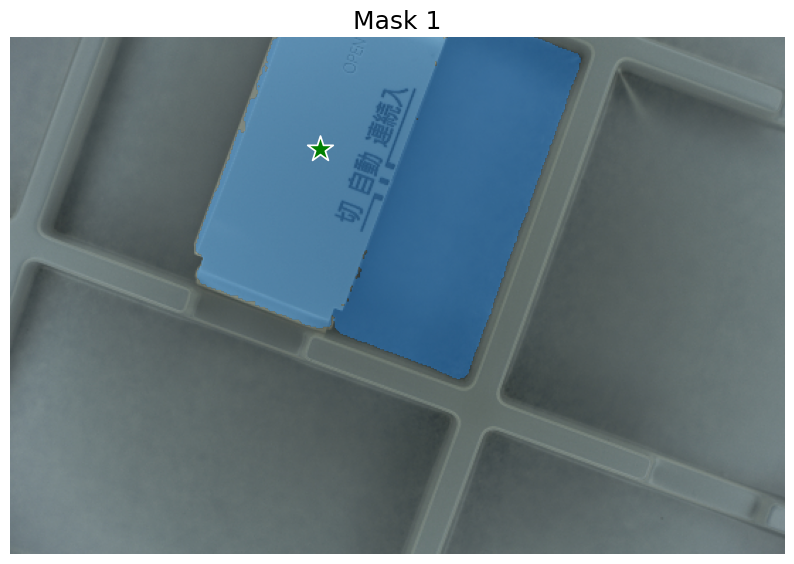

True

In [63]:
# Save masks
plt.figure(figsize=(10, 10))
plt.imshow(test_image)
show_mask(masks[best_idx], plt.gca())
show_points(topk_xy, topk_label, plt.gca())
plt.title(f"Mask {best_idx}", fontsize=18)
plt.axis('off')
vis_mask_output_path = os.path.join(output_path, f'vis_mask_{file_name}.{ext}')
with open(vis_mask_output_path, 'wb') as outfile:
    plt.savefig(outfile, format=ext)
plt.show()

final_mask = masks[best_idx]
mask_colors = np.zeros((final_mask.shape[0], final_mask.shape[1], 3), dtype=np.uint8)
mask_colors[final_mask, :] = np.array([[0, 0, 128]])
mask_output_path = os.path.join(output_path, f'{file_name}.{ext}')
cv2.imwrite(mask_output_path, mask_colors)

In [ ]:
from scipy.ndimage import maximum_filter
sim_cpu = sim.cpu().detach().numpy()
filter_size=200
order=0.8
local_max = maximum_filter(sim_cpu, footprint=np.ones((filter_size, filter_size)), mode='constant')
detected_peaks = np.ma.array(sim_cpu, mask=~(sim_cpu == local_max))

# 小さいピーク値を排除（最大ピーク値のorder倍のピークは排除）
temp = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
# peaks_index = np.where(temp.mask != True)
# peaks_index = list(zip(*peaks_index))
peaks_index = np.argwhere(temp.mask != True)
# print(peaks_index)
# print(peaks_index[:,[1,0]])
peaks_index = peaks_index[:,[1,0]]
print(peaks_index)


In [ ]:
heatmap = sim_to_heatmap(sim)

for peak in peaks_index:
    cv2.circle(heatmap, (peak[0], peak[1]), radius=3, color=(0, 0, 0), thickness=-1)
    cv2.putText(heatmap, 'PEAK!!!', (peak[0], peak[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)    
    # plt.scatter(peaks_index[1][i], peaks_index[0][i], color='black', s=5)
    # plt.text(peaks_index[1][i],peaks_index[0][i], 'PEAK!!!', fontsize=9)
# plt.axis("off")
# plt.savefig("positon_detector_similarity.jpg")
plt.imshow(heatmap)
plt.show()

In [ ]:
peak_label = np.array([1])
for peak_xy in peaks_index:
    peak_xy = peak_xy[np.newaxis, :]
    print(peak_xy, peak_label)
    # First-step prediction
    masks, scores, logits, logits_high = predictor.predict(
                point_coords=peak_xy,
                point_labels=peak_label,
                multimask_output=True)

    # Weighted sum three-scale masks
    logits_high = logits_high * weights.unsqueeze(-1)
    logit_high = logits_high.sum(0)
    mask = (logit_high > 0).detach().cpu().numpy()

    logits = logits * weights_np[..., None]
    logit = logits.sum(0)

    # Cascaded Post-refinement-1
    y, x = np.nonzero(mask)
    x_min = x.min()
    x_max = x.max()
    y_min = y.min()
    y_max = y.max()
    input_box = np.array([x_min, y_min, x_max, y_max])
    masks, scores, logits, _ = predictor.predict(
        point_coords=peak_xy,
        point_labels=peak_label,
        box=input_box[None, :],
        mask_input=logit[None, :, :],
        multimask_output=True)
    best_idx = np.argmax(scores)

    # Cascaded Post-refinement-2
    y, x = np.nonzero(masks[best_idx])
    x_min = x.min()
    x_max = x.max()
    y_min = y.min()
    y_max = y.max()
    input_box = np.array([x_min, y_min, x_max, y_max])
    masks, scores, logits, _ = predictor.predict(
        point_coords=peak_xy,
        point_labels=peak_label,
        box=input_box[None, :],
        mask_input=logits[best_idx: best_idx + 1, :, :],
        multimask_output=True)
    best_idx = np.argmax(scores)

    plt.figure(figsize=(10, 10))
    plt.imshow(test_image)
    show_mask(masks[best_idx], plt.gca())
    print(peak_xy, peak_label)
    show_points(peak_xy, peak_label, plt.gca())
    plt.title(f"Mask {best_idx}", fontsize=18)
    plt.axis('off')
    vis_mask_output_path = os.path.join(output_path, f'vis_mask_{file_name}.{ext}')
    with open(vis_mask_output_path, 'wb') as outfile:
        plt.savefig(outfile, format=ext)
    plt.show()

In [ ]:
print(topk_xy, topk_label)

In [ ]:
peak_label